In [1]:
import pandas as pd
import numpy as np

import plotly.express as px

import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio

pio.renderers.default = "vscode"

In [2]:
distances = pd.read_excel("../../data/ExtendedNuclearData.xlsx", sheet_name="Transport")

In [3]:
distances_dict = dict()
for idx, row in distances[distances["is_possible"] != 0].iterrows():
    org = row["from"]
    dest = row["to"]

    dist = row["costs"]

    if org in distances_dict.keys():
        relations_from_org = distances_dict[org]
        relations_from_org[dest] = dist
    else:
        relations_from_org = dict()
        relations_from_org[dest] = dist
        distances_dict[org] = relations_from_org

In [4]:
with open('../parameter_config.yaml', 'r') as file:
    config_data = yaml.safe_load(file)

In [5]:
transport_costs_per_km = config_data["transport_costs"]["cost_factor"]
transport_factor = config_data["transport_costs"]["nuclear_factor"]

In [6]:
construction_costs = config_data["cisf"]["versions"]
versions = dict()

for cisf_dict in construction_costs:
    k = cisf_dict["size"]
    v = cisf_dict["costs"]
    versions[k] = v

In [7]:
snf_dict = {}
nc_dict = {}
cisf_dict = {}
hc_dict = {}
for n_hc in config_data["hot_cells"]["max_count"]:
    for n_cisf in config_data["cisf"]["count"]:
        if n_hc is None:
            n_hc = "nothing"
        if n_cisf is None:
            n_cisf = "nothing"
        snf = pd.read_csv(f"../../storage/n_hc_{n_hc}/n_cisf_{n_cisf}/snf_shipped.csv")
        nc = pd.read_csv(f"../../storage/n_hc_{n_hc}/n_cisf_{n_cisf}/nc_shipped.csv")
        cisf = pd.read_csv(f"../../storage/n_hc_{n_hc}/n_cisf_{n_cisf}/cisf_build.csv")
        hc = pd.read_csv(f"../../storage/n_hc_{n_hc}/n_cisf_{n_cisf}/hc_build.csv")

        snf_dict[f"n_hc_{n_hc}-n_cisf_{n_cisf}"] = snf
        nc_dict[f"n_hc_{n_hc}-n_cisf_{n_cisf}"] = nc
        cisf_dict[f"n_hc_{n_hc}-n_cisf_{n_cisf}"] = cisf
        hc_dict[f"n_hc_{n_hc}-n_cisf_{n_cisf}"] = hc

##### Transport costs

In [8]:
def calculate_transport_costs(snf, nc):
    snf_shipped = snf[snf["SNF"] != 0]
    nc_shipped = nc[nc["NC"] != 0]

    shipped = pd.concat([snf_shipped.rename(columns={"SNF": "amount"}), nc_shipped.rename(columns={"NC": "amount"})])

    distances["key"] = distances["from"] + distances["to"]
    shipped["key"] = shipped["from"] + shipped["to"]

    shipped = pd.merge(left=shipped, left_on="key", right=distances.drop(columns=["from", "to", "is_possible"]), right_on="key", how="left").drop(columns="key")
    shipped["transport_costs"] = shipped["costs"] * shipped["amount"] * transport_costs_per_km * transport_factor

    total_transport_costs = np.sum(shipped["transport_costs"])

    return total_transport_costs

##### CISF costs

In [9]:
def calculate_cisf_costs(cisf):
    built = cisf[cisf["build"] == 1]

    versions_built = built.groupby(by="size", as_index=False).agg(n = ("build", "sum"))

    total_cisf_construction_costs = 0

    for idx, row in versions_built.iterrows():
        total_cisf_construction_costs += row["n"] * versions[row["size"]]
    
    return total_cisf_construction_costs

##### Hot Cell costs

In [10]:
def calculate_hc_costs(hc, nc):
    hc_construction_cost = config_data["hot_cells"]["construction_cost"]
    processing_cost = config_data["hot_cells"]["processing_cost"]

    total_hc_construction_cost = sum(hc["build"]) * hc_construction_cost[0]
    
    nc_shipped = nc[nc["NC"] != 0]
    total_processing_costs = np.sum(nc_shipped["NC"]) * processing_cost

    return total_hc_construction_cost, total_processing_costs

##### Plotting

In [30]:
# Prepare data for the heatmap
data = []

for n_hc in config_data["hot_cells"]["max_count"]:
    for n_cisf in config_data["cisf"]["count"]:
        if n_hc is None:
            n_hc = "nothing"
        if n_cisf is None:
            n_cisf = "nothing"

            
        key = f"n_hc_{n_hc}-n_cisf_{n_cisf}"
        snf = snf_dict[key]
        nc = nc_dict[key]
        cisf = cisf_dict[key]
        hc = hc_dict[key]
        
        total_costs = (
            calculate_transport_costs(snf, nc) +
            calculate_cisf_costs(cisf) +
            sum(calculate_hc_costs(hc, nc))
        )
        
        data.append({
            "n_hc": n_hc,
            "n_cisf": n_cisf,
            "total_costs": total_costs,
            "transport_costs": calculate_transport_costs(snf, nc),
            "cisf_costs": calculate_cisf_costs(cisf),
            "hc_costs": sum(calculate_hc_costs(hc, nc))
        })

# Convert to DataFrame
df = pd.DataFrame(data)

In [31]:
df[df["n_hc"].isin([1,2]) & df["n_cisf"].isin([1,2])]

,n_hc,n_cisf,total_costs,transport_costs,cisf_costs,hc_costs
0,1,1,5.671984e+09,2.015280e+09,3.417033e+08,3.315000e+09
1,1,2,5.858138e+09,2.144763e+09,3.983756e+08,3.315000e+09
8,2,1,5.787875e+09,2.041172e+09,3.417033e+08,3.405000e+09
9,2,2,4.957594e+09,1.154219e+09,3.983756e+08,3.405000e+09


In [32]:
df.sort_values("total_costs")

,n_hc,n_cisf,total_costs,transport_costs,cisf_costs,hc_costs
27,4,4,4.767157e+09,6.571801e+08,5.249773e+08,3.585000e+09
36,5,5,4.839940e+09,5.899195e+08,5.750209e+08,3.675000e+09
28,4,5,4.853681e+09,6.936597e+08,5.750209e+08,3.585000e+09
35,5,4,4.856749e+09,6.567716e+08,5.249773e+08,3.675000e+09
18,3,3,4.869976e+09,9.464426e+08,4.285333e+08,3.495000e+09
19,3,4,4.877202e+09,8.572248e+08,5.249773e+08,3.495000e+09
26,4,3,4.952902e+09,9.393688e+08,4.285333e+08,3.585000e+09
37,5,6,4.953188e+09,6.531232e+08,6.250646e+08,3.675000e+09
9,2,2,4.957594e+09,1.154219e+09,3.983756e+08,3.405000e+09
44,6,5,4.960058e+09,6.200374e+08,5.750209e+08,3.765000e+09


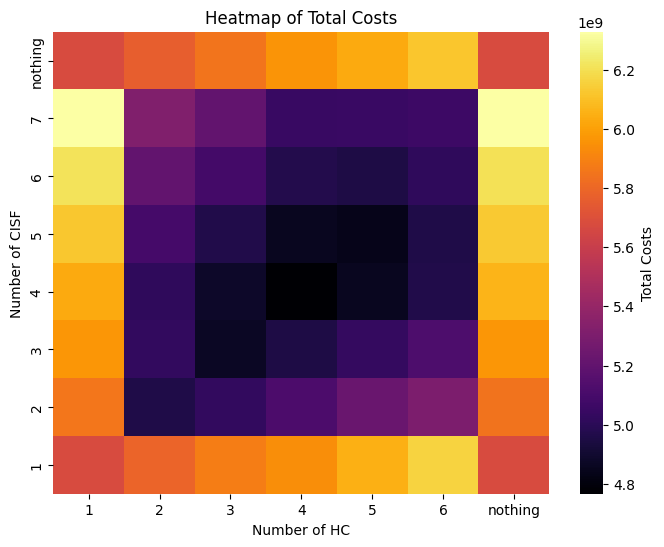

In [33]:
# Pivot the data to create a matrix format suitable for heatmap
heatmap_data = df.pivot(index="n_cisf", columns="n_hc", values="total_costs")
heatmap_data = heatmap_data[::-1]
# Create the heatmap with Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=False, fmt=".1f", cmap="inferno", cbar_kws={'label': 'Total Costs'})
plt.title("Heatmap of Total Costs")
plt.xlabel("Number of HC")
plt.ylabel("Number of CISF")
plt.show()

In [ ]:
# Pivot the data to create a matrix format suitable for imshow
heatmap_data = df.pivot(index="n_cisf", columns="n_hc", values="total_costs")
# Create heatmap with Plotly Express
px.imshow(heatmap_data, labels={'x': 'Number of HC', 'y': 'Number of CISF', 'color': 'Total Costs'},
                color_continuous_scale='Viridis')


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'hovertemplate': 'Number of HC: %{x}<br>Number of CISF: %{y}<br>Total Costs: %{z}<extra></extra>',
              'name': '0',
              'type': 'heatmap',
              'x': array([1, 2, 3, 4, 5, 6, 'nothing'], dtype=object),
              'xaxis': 'x',
              'y': array([1, 2, 3, 4, 5, 6, 7, 'nothing'], dtype=object),
              'yaxis': 'y',
              'z': array([[5.67198376e+09, 5.78799361e+09, 5.87772354e+09, 5.96682496e+09,
                           6.05699289e+09, 6.14810154e+09, 5.67198376e+09],
                          [5.84136819e+09, 4.93413931e+09, 5.02373191e+09, 5.11373191e+09,
                           5.20952626e+09, 5.29308489e+09, 5.84136819e+09],
                          [5.96207342e+09, 5.02591802e+09, 4.86997584e+09, 4.94364009e+09,
                           5.03290569e+09, 5.12321889e+09, 5.96207342e+09],
                          [6.03051995e+09, 5.03815955e+09, 4.87720212e+09, 4.76715740e+09,
                           4.85715740e+09, 4.95198350e+09, 6.07164072e+09],
                          [6.11924294e+09, 5.09456714e+09, 4.97185882e+09, 4.85368064e+09,
                           4.83994042e+09, 4.92953197e+09, 6.11174332e+09],
                          [6.19806444e+09, 5.24109766e+09, 5.08819314e+09, 4.97814841e+09,
                           4.94786926e+09, 5.00898361e+09, 6.23730804e+09],
                          [6.34123241e+09, 5.30445739e+09, 5.17849286e+09, 5.03580311e+09,
                           5.02206289e+09, 4.99634494e+09, 6.35156846e+09],
                          [5.67198376e+09, 5.76131424e+09, 5.85080364e+09, 5.94058524e+09,
                           6.03018414e+09, 6.12010494e+09, 5.67198376e+09]])}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'Total Costs'}},
                             'colorscale': [[0.0, '#440154'], [0.1111111111111111,
                                            '#482878'], [0.2222222222222222,
                                            '#3e4989'], [0.3333333333333333,
                                            '#31688e'], [0.4444444444444444,
                                            '#26828e'], [0.5555555555555556,
                                            '#1f9e89'], [0.6666666666666666,
                                            '#35b779'], [0.7777777777777778,
                                            '#6ece58'], [0.8888888888888888,
                                            '#b5de2b'], [1.0, '#fde725']]},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y',
                         'constrain': 'domain',
                         'domain': [0.0, 1.0],
                         'scaleanchor': 'y',
                         'title': {'text': 'Number of HC'}},
               'yaxis': {'anchor': 'x',
                         'autorange': 'reversed',
                         'constrain': 'domain',
                         'domain': [0.0, 1.0],
                         'title': {'text': 'Number of CISF'}}}
})

In [ ]:
rows = []

rows.append({
    "cost_center": "transport",
    "amount": total_transport_costs
})

rows.append({
    "cost_center": "cisf",
    "amount": total_cisf_construction_costs
})

rows.append({
    "cost_center": "hc_construction",
    "amount": total_hc_construction_cost
})

rows.append({
    "cost_center": "hc_processing",
    "amount": total_processing_costs
})

costs = pd.DataFrame(rows)

NameError: name 'total_hc_construction_cost' is not defined

In [ ]:
px.bar(costs,
       x="cost_center",
       y="amount",
       template="seaborn",
       labels={"cost_center": "Cost center",
               "amount": "Amount [EUR]"})